In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
from tqdm import tqdm
import argparse

import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torchvision.utils import save_image


from autoencoder import Autoencoder
from solver import *
from receptive_field import get_RF_linear

%load_ext autoreload
%autoreload 2

### Load model

In [71]:
modelpath = '/home/david/sparsify_models/good_models/01/'
plotpath = '/home/david/sparsify_plots/RF/'
if not os.path.exists(plotpath):
    os.makedirs(plotpath)

In [72]:
n_input = 28*28
n_layers = 3
sae_n_hidden_ls = [512, 128, 32]
dae_n_hidden_ls = [512, 128, 32]

sae = Autoencoder(n_input,sae_n_hidden_ls,n_layers)
dae = Autoencoder(n_input,dae_n_hidden_ls,n_layers)

In [73]:
sae_weights = torch.load(modelpath + 'SAE/model_weights_epoch49.pth')
sae.load_state_dict(sae_weights)

dae_weights = torch.load(modelpath + 'DAE/model_weights_epoch49.pth')
dae.load_state_dict(dae_weights)

/tmp/ipykernel_9440/2719718091.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sae_weights = torch.load(modelpath + 'SAE/model_weights_epoch49.pth')
/tmp/ipykernel_9440/

<All keys matched successfully>

### Load data

In [74]:
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

batch_size = 128
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=6)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=6)

In [19]:
from torch.utils.data import DataLoader, TensorDataset

test_images = []
test_labels = []

for batch_idx, (data, target) in enumerate(test_loader):
    data = Variable(data).to('cuda')
    input = data.view(data.size(0), -1).to('cuda')
    test_images.append(input.cpu().numpy())
    test_labels.append(target.cpu().numpy())

test_images = np.concatenate(test_images)
test_labels = np.concatenate(test_labels)


sae_encodings = []

with torch.no_grad():
    for image in test_images:
        image = torch.tensor(image).to('cpu')
        input = image.view(1, -1).to('cpu')
        encoded, decoded = sae(input)
        sae_encodings.append(encoded.cpu().detach())

sae_encodings_tensor = torch.cat(sae_encodings)


dae_encodings = []

with torch.no_grad():
    for image in test_images:
        image = torch.tensor(image).to('cpu')
        input = image.view(1, -1).to('cpu')
        encoded, decoded = sae(input)
        dae_encodings.append(encoded.cpu().detach())

dae_encodings_tensor = torch.cat(dae_encodings)

# Create a new DataLoader with the encodings
sae_encoding_dataset = TensorDataset(sae_encodings_tensor, torch.tensor(test_labels))
sae_encoding_loader = DataLoader(sae_encoding_dataset, batch_size=64, shuffle=False)

dae_encoding_dataset = TensorDataset(dae_encodings_tensor, torch.tensor(test_labels))
dae_encoding_loader = DataLoader(dae_encoding_dataset, batch_size=64, shuffle=False)

In [20]:
dummy_labels = torch.zeros(len(sae_encodings_tensor))
sae_encoding_dataset = TensorDataset(sae_encodings_tensor, dummy_labels)
encoding_loader = DataLoader(sae_encoding_dataset, batch_size=64, shuffle=False)

dummy_labels = torch.zeros(len(dae_encodings_tensor))
dae_encoding_dataset = TensorDataset(dae_encodings_tensor, dummy_labels)
encoding_loader = DataLoader(dae_encoding_dataset, batch_size=64, shuffle=False)

### Linear Receptive Field

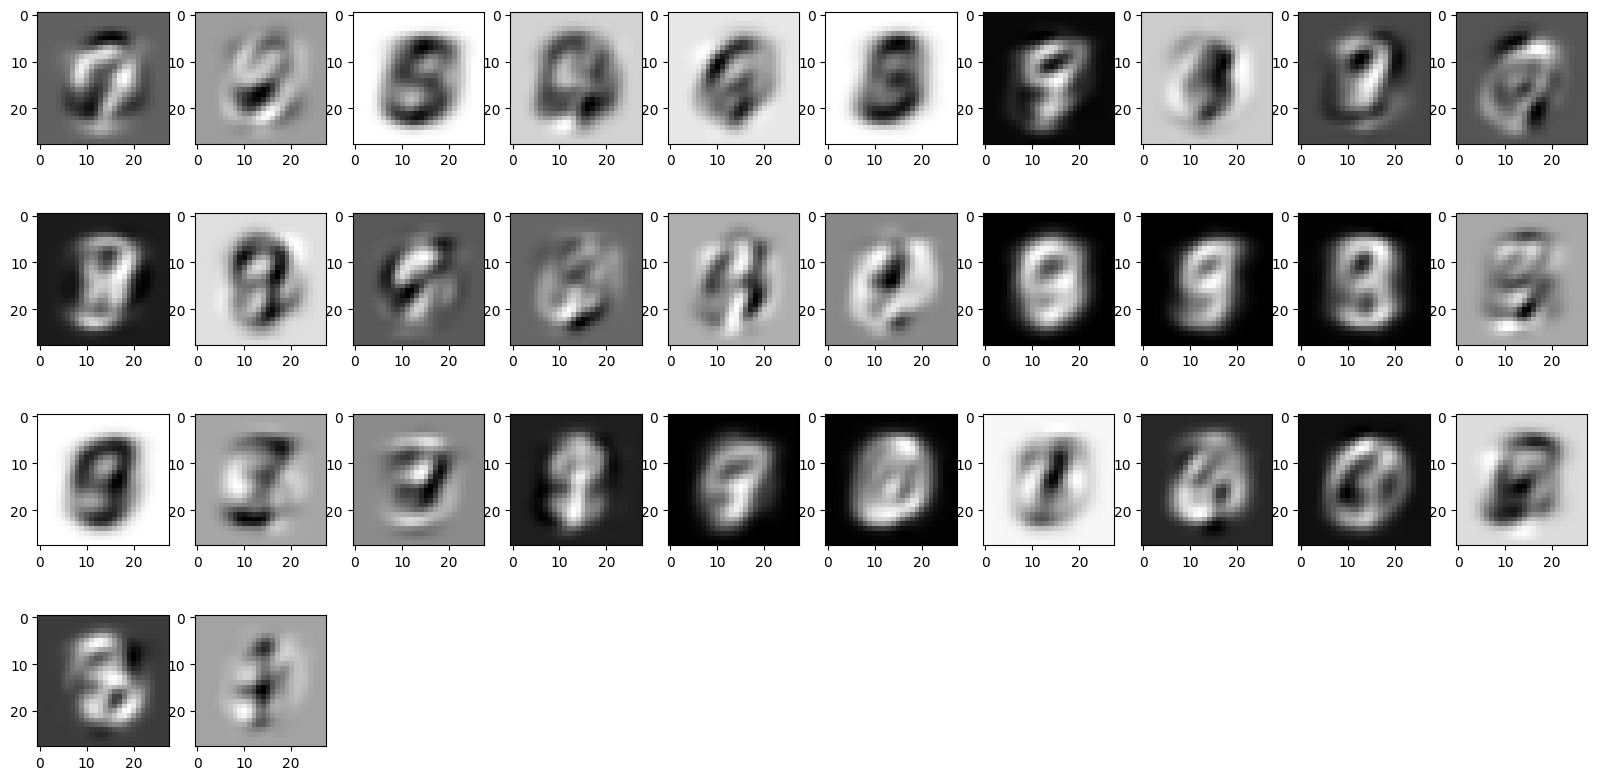

In [80]:
rf_sae = get_RF_linear(sae, mnist_test)

fig = plt.figure(figsize=(20,10))

for i,rf in enumerate(rf_sae):
    plt.subplot(4,10,i+1)
    plt.imshow(rf.reshape(28,28),cmap='binary_r')

plt.savefig(plotpath + 'sae_linear.pdf',bbox_inches='tight')

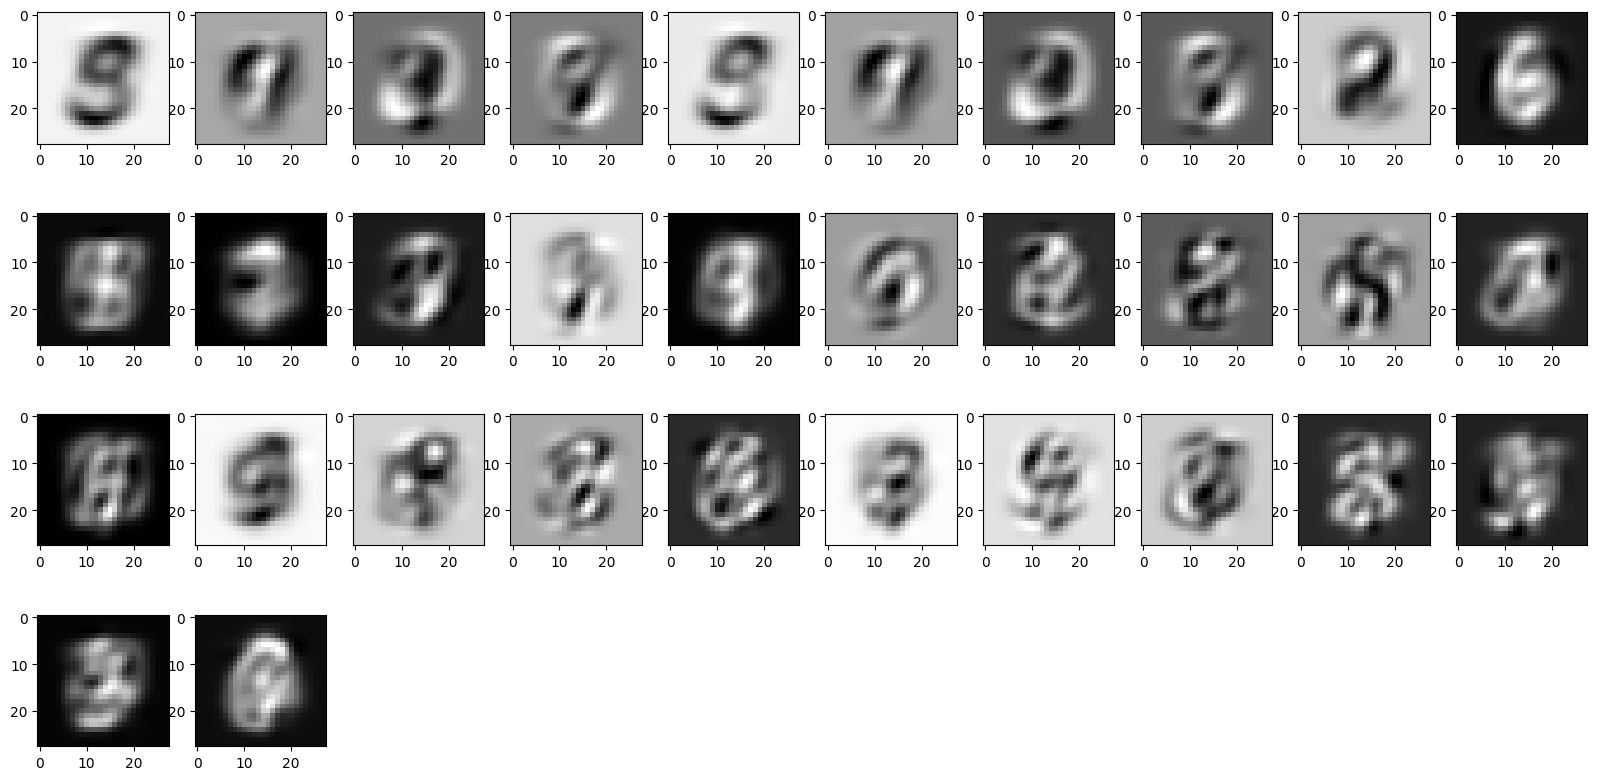

In [81]:
rf_dae = get_RF_linear(dae, mnist_test)

fig = plt.figure(figsize=(20,10))

for i,rf in enumerate(rf_dae):
    plt.subplot(4,10,i+1)
    plt.imshow(rf.reshape(28,28),cmap='binary_r')

plt.savefig(plotpath + 'dae_linear.pdf',bbox_inches='tight')

In [83]:
with torch.no_grad():
    for rf in rf_dae:
        input = torch.tensor(rf).to('cpu')
        encoded, decoded = dae(input)
        absolute_encoded = torch.abs(encoded)
        print(torch.argmax(absolute_encoded))

tensor(8)
tensor(8)
tensor(8)
tensor(8)
tensor(8)
tensor(8)
tensor(8)
tensor(8)
tensor(8)
tensor(9)
tensor(10)
tensor(8)
tensor(12)
tensor(8)
tensor(14)
tensor(8)
tensor(8)
tensor(8)
tensor(8)
tensor(8)
tensor(20)
tensor(8)
tensor(8)
tensor(8)
tensor(8)
tensor(8)
tensor(8)
tensor(8)
tensor(8)
tensor(8)
tensor(8)
tensor(8)


/tmp/ipykernel_9440/1181932203.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(rf).to('cpu')


In [90]:
sae_encoded_list = []
dae_encoded_list = []

with torch.no_grad():
    for rf in rf_sae:
        input = torch.tensor(rf).to('cpu')
        encoded, decoded = sae(input)
        sae_absolute_encoded = torch.abs(encoded)
        sae_encoded_list.append(sae_absolute_encoded.cpu().numpy())

with torch.no_grad():
    for rf in rf_dae:
        input = torch.tensor(rf).to('cpu')
        encoded, decoded = dae(input)
        dae_absolute_encoded = torch.abs(encoded)
        dae_encoded_list.append(dae_absolute_encoded.cpu().numpy())

/tmp/ipykernel_9440/2365229988.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(rf).to('cpu')
/tmp/ipykernel_9440/2365229988.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(rf).to('cpu')


Shape of dae_rf_ls: (32, 32)


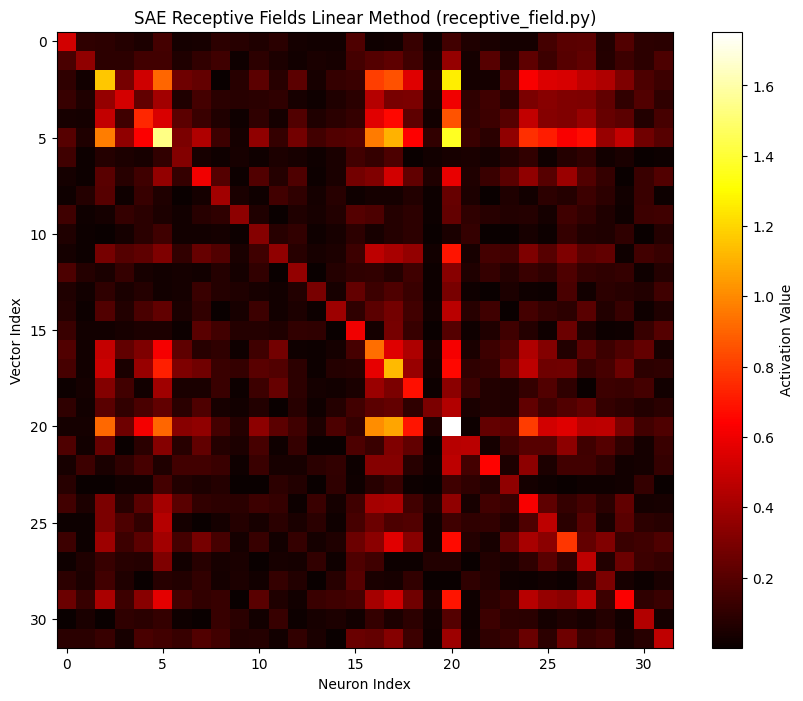

In [95]:
import matplotlib.pyplot as plt
import numpy as np

sae_encoded_list = np.array(sae_encoded_list)

print("Shape of dae_rf_ls:", sae_encoded_list.shape)

# Create the heatmap
plt.figure(figsize=(10, 8))
plt.imshow(sae_encoded_list, cmap='hot', interpolation='nearest')
plt.colorbar(label='Activation Value')
plt.xlabel('Neuron Index')
plt.ylabel('Vector Index')
plt.title('SAE Receptive Fields Linear Method (receptive_field.py)')
plt.show()

Shape of dae_rf_ls: (32, 32)


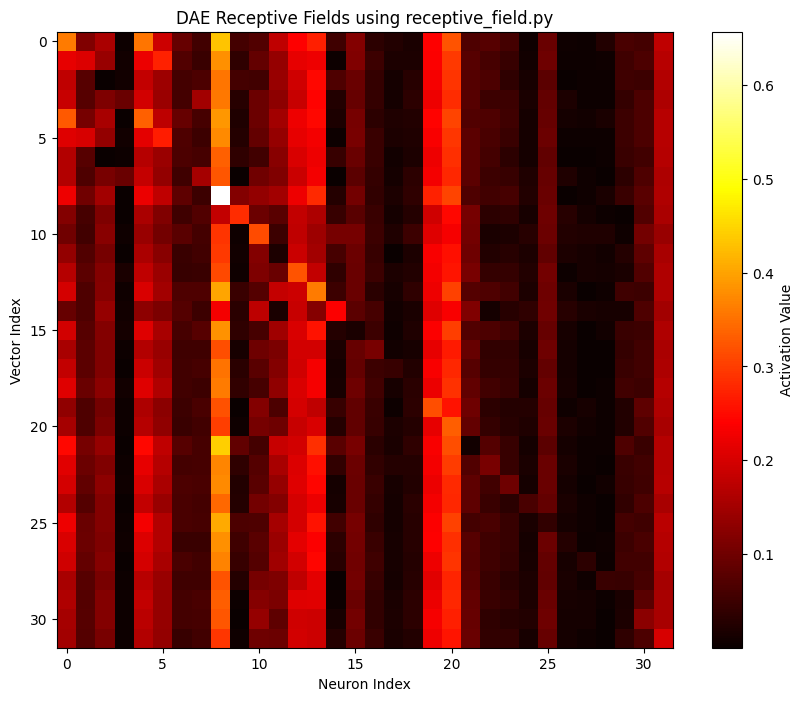

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

dae_encoded_list = np.array(dae_encoded_list)

print("Shape of dae_rf_ls:", dae_encoded_list.shape)

# Create the heatmap
plt.figure(figsize=(10, 8))
plt.imshow(dae_encoded_list, cmap='hot', interpolation='nearest')
plt.colorbar(label='Activation Value')
plt.xlabel('Neuron Index')
plt.ylabel('Vector Index')
plt.title('DAE Receptive Fields Linear Method (receptive_field.py)')
plt.show()

In [88]:
with torch.no_grad():
    input = torch.tensor(rf_dae[0]).to('cpu')
    encoded, decoded = dae(input)
    absolute_encoded = torch.abs(encoded)
    print(torch.argmax(absolute_encoded))

tensor(8)


/tmp/ipykernel_9440/304418788.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(rf_dae[0]).to('cpu')


In [52]:
test_images = []
test_labels = []

for batch_idx, (data, target) in enumerate(test_loader):
    data = Variable(data).to('cuda')
    input = data.view(data.size(0), -1).to('cuda')
    test_images.append(input.cpu().numpy())
    test_labels.append(target.cpu().numpy())

test_images = np.concatenate(test_images)
test_labels = np.concatenate(test_labels)

In [75]:
import matplotlib.pyplot as plt
import torch

sae_absolute_encoded_list = []
dae_absolute_encoded_list = []

with torch.no_grad():
    for image in test_images:
        image = torch.tensor(rf).to('cpu')
        input = image.view(1, -1).to('cpu')
        encoded, decoded = sae(input)
        sae_absolute_encoded = torch.abs(encoded)
        sae_absolute_encoded_list.append(sae_absolute_encoded.cpu().numpy())
        
        encoded, decoded = dae(input)
        dae_absolute_encoded = torch.abs(encoded)
        dae_absolute_encoded_list.append(dae_absolute_encoded.cpu().numpy())

sae_absolute_encoded_array = np.array(sae_absolute_encoded_list)
dae_absolute_encoded_array = np.array(dae_absolute_encoded_list)

sae_mean_activation = np.mean(sae_absolute_encoded_array, axis=0)
dae_mean_activation = np.mean(dae_absolute_encoded_array, axis=0)

print("SAE Mean Activation:", sae_mean_activation)
print("DAE Mean Activation:", dae_mean_activation)

sae_std_activation = np.std(sae_absolute_encoded_array, axis=0)
dae_std_activation = np.std(dae_absolute_encoded_array, axis=0)

print("SAE Standard Deviation of Activation:", sae_std_activation)
print("DAE Standard Deviation of Activation:", dae_std_activation)

/tmp/ipykernel_9440/3676277844.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(rf).to('cpu')


SAE Mean Activation: [[0.0066117  0.01278496 0.55534464 0.14331874 0.40452555 0.6226886
  0.18459769 0.17847554 0.09533589 0.14501949 0.15836416 0.04238718
  0.09392919 0.08148079 0.2203522  0.02337672 0.4807912  0.551261
  0.32885274 0.05145076 0.9316154  0.07094041 0.12317207 0.10813986
  0.45925513 0.40679964 0.37322736 0.4247598  0.22362615 0.29467663
  0.02988667 0.05111683]]
DAE Mean Activation: [[0.40216097 0.1887534  0.25634193 0.03032164 0.38330072 0.26700088
  0.18313946 0.08488587 0.567385   0.07436076 0.07329814 0.20825233
  0.2680676  0.32423413 0.10253908 0.13597502 0.04676079 0.02199875
  0.05325028 0.20828152 0.38299525 0.02132728 0.0819512  0.08076494
  0.01569539 0.0751548  0.00903868 0.03106767 0.05748959 0.06839766
  0.05343455 0.16170451]]
SAE Standard Deviation of Activation: [[3.47859526e-07 1.71729732e-06 1.74034376e-05 7.97194753e-06
  4.54774781e-05 4.48809478e-05 1.53775836e-05 2.08174170e-05
  6.37057383e-06 1.53475867e-06 1.67640374e-05 2.33215815e-06
  8.4

In [76]:
sae_sum_first_16 = np.sum(sae_mean_activation[0][0:16])
sae_sum_last_16 = np.sum(sae_mean_activation[0][16:32])

print("Sum of first 16 elements of SAE Mean Activation:", sae_sum_first_16)
print("Sum of last 16 elements of SAE Mean Activation:", sae_sum_last_16)

Sum of first 16 elements of SAE Mean Activation: 2.9685931
Sum of last 16 elements of SAE Mean Activation: 4.9095716


In [77]:
dae_sum_first_16 = np.sum(dae_mean_activation[0][0:16])
dae_sum_last_16 = np.sum(dae_mean_activation[0][16:32])

print("Sum of first 16 elements of DAE Mean Activation:", dae_sum_first_16)
print("Sum of last 16 elements of DAE Mean Activation:", dae_sum_last_16)

Sum of first 16 elements of DAE Mean Activation: 3.5500169
Sum of last 16 elements of DAE Mean Activation: 1.3693128


In [65]:
dae_mean_activation[0][0:16]

array([0.1519698 , 0.4496516 , 0.24414694, 0.1241335 , 0.10784531,
       0.48731732, 0.20009853, 0.10124478, 0.13978164, 0.28173965,
       0.10058502, 0.16073686, 0.13305606, 0.1345099 , 0.02345354,
       0.22751802], dtype=float32)

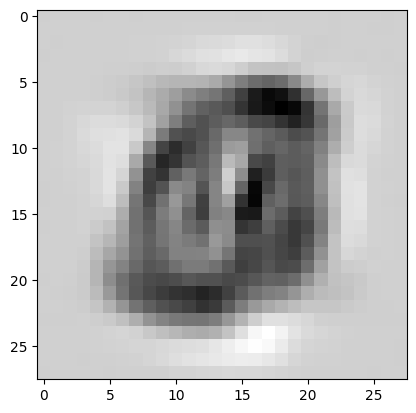

In [38]:
plt.imshow(decoded.cpu().numpy().reshape(28,28),cmap='binary_r')

### Activation Maximization

In [ ]:
import act_max_util as amu
activation_dictionary = {}
layer_name = 'bottle_neck'

sae.encoder.encoder_3.register_forward_hook(amu.layer_hook(activation_dictionary, layer_name))

In [ ]:
data = torch.randn(28, 28)
data = data.unsqueeze(0)
input = data.view(data.size(0), -1)
input.requires_grad_(True)

print(input.shape)

In [ ]:
steps = 100                 # perform 100 iterations
unit = 0                 # flamingo class of Imagenet
alpha = torch.tensor(100)   # learning rate (step size) 
verbose = False              # print activation every step
L2_Decay = True             # enable L2 decay regularizer
Gaussian_Blur = False        # enable Gaussian regularizer
Norm_Crop = False            # enable norm regularizer
Contrib_Crop = False         # enable contribution regularizer

In [ ]:
sae_rf_ls = []
for i in range(32):
    output = amu.act_max(network=sae,
                    input=input,
                    layer_activation=activation_dictionary,
                    layer_name=layer_name,
                    unit=i,
                    steps=steps,
                    alpha=alpha,
                    verbose=verbose,
                    L2_Decay=L2_Decay,
                    Gaussian_Blur=Gaussian_Blur,
                    Norm_Crop=Norm_Crop,
                    Contrib_Crop=Contrib_Crop,
                    )
    sae_rf_ls.append(output.detach().numpy())

In [ ]:
fig = plt.figure(figsize=(20,10))
for i in range(32):
    plt.subplot(4,10,i+1)
    plt.imshow(sae_rf_ls[i].reshape(28,28),cmap='binary_r')
plt.savefig(plotpath + 'sae_maxact.pdf',bbox_inches='tight')

In [ ]:
activation_dictionary = {}
layer_name = 'bottle_neck'

dae.encoder.encoder_3.register_forward_hook(amu.layer_hook(activation_dictionary, layer_name))

In [ ]:
dae_rf_ls = []
for i in range(32):
    output = amu.act_max(network=dae,
                    input=input,
                    layer_activation=activation_dictionary,
                    layer_name=layer_name,
                    unit=i,
                    steps=steps,
                    alpha=alpha,
                    verbose=verbose,
                    L2_Decay=L2_Decay,
                    Gaussian_Blur=Gaussian_Blur,
                    Norm_Crop=Norm_Crop,
                    Contrib_Crop=Contrib_Crop,
                    )
    dae_rf_ls.append(output.detach().numpy())

In [ ]:
fig = plt.figure(figsize=(20,9))
for i in range(32):
    plt.subplot(4,10,i+1)
    plt.title(str(i+1))
    plt.imshow(dae_rf_ls[i].reshape(28,28),cmap='binary_r')
plt.savefig(plotpath + 'dae_maxact.pdf',bbox_inches='tight')

In [ ]:
diff = dae_rf_ls[4] - dae_rf_ls[0]
plt.imshow(diff.reshape(28,28),cmap='binary_r')
plt.colorbar()